In [13]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt


# MODELO: 2N5486 - NJFET

***
**VALORES DE HOJA DE DATOS**
- IDSS: [8,20]ma
- VP: [-2,-6]V
- rgs: 1M
- ro: inf

In [14]:
VDD=12
RS=470
RG1=820e3
RG2=100e3
IDSSMAX=20e-3
IDSSMIN=8e-3
VPMAX=-6
VPMIN=-2
RD=1e3
RL=10e3


# Calculo punto de polarizacion para el caso de transferencia minima

In [15]:
RG=RG1*RG2/(RG1+RG2)
VGG=VDD*RG2/(RG1+RG2)
a=(RS/VPMIN)**2
b=( ((2*RS/VPMIN)*(1-(VGG/VPMIN)))-(1/IDSSMIN) )
c=(1-(VGG/VPMIN))**2
IDQ=(-b-np.sqrt(b**2 -4*a*c))/(2*a)
gm=(-2/VPMIN)*np.sqrt(IDQ*IDSSMIN)
AV=-gm*(RD*RL)/(RD+RL)
rgs=1e6
ri=(rgs*RG)/(RG+rgs)

In [16]:
parametrosJFET = pd.DataFrame(np.array([[VDD, 
                              RG1, 
                              RG2,
                              RS,
                              RD,
                              RL,
                              VGG,
                              RG,
                              IDQ,
                              gm,
                              AV,
                              rgs,
                              ri]]),
                   columns=['VDD',
                            'RG1', 
                            'RG2',
                            'RS',
                            'RD',
                            'RL',
                            'VGG',
                            'RG',
                            'IDQ',
                            'gm',
                            'AV',
                            'rig',
                            'ri'])
parametrosJFET

,VDD,RG1,RG2,RS,RD,RL,VGG,RG,IDQ,gm,AV,rig,ri
0,12.0,820000.0,100000.0,470.0,1000.0,10000.0,1.304348,89130.434783,0.004016,0.005668,-5.15266,1000000.0,81836.327345


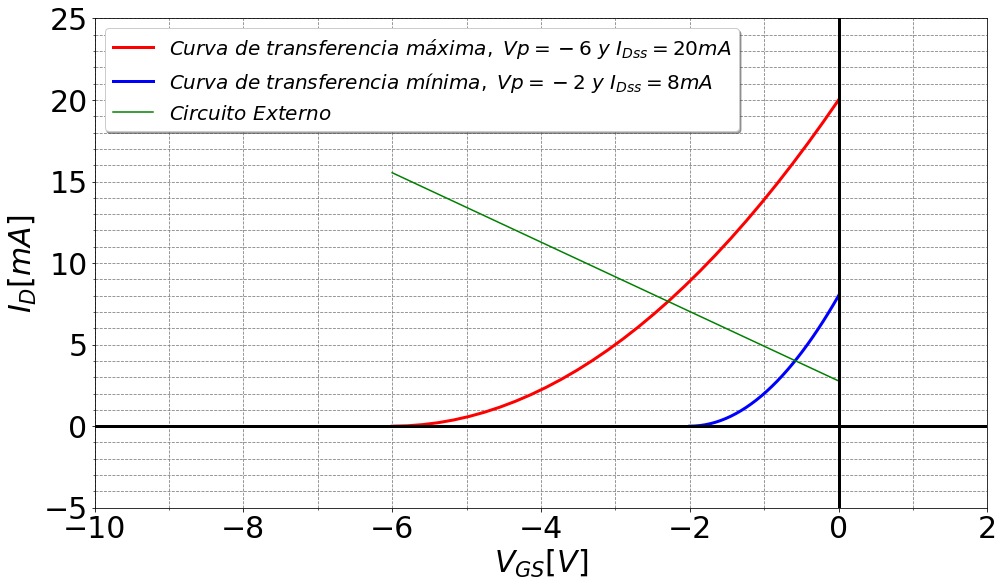

In [17]:
fig = plt.figure(figsize=[16, 9])
ax = fig.gca()
#Aca establezco la subdivicion del grafico
ax.set_xticks(np.linspace(-10, 2, 13), minor=True)
ax.set_yticks(np.linspace(-5,25, 31), minor=True)

ax.tick_params(axis='both', labelsize=30)

#Parametros en los cuatro lados
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = True

#1000*EJERCICIO_A_1_A['time'] es para poner la escala en mili segundos

#SEÑAL DE ENTRADA Vi
vgsMax=np.linspace(-6, 0, 30)
vgsMin=np.linspace(-2, 0, 30)

plt.plot(vgsMax, 20*(1-vgsMax/(-6))**2,linewidth=3.0,c='r',label='$Curva\ de\ transferencia\ máxima,\ Vp=-6\ y\ I_{Dss}=20mA$')
plt.plot(vgsMin, 8*(1-vgsMin/(-2))**2,linewidth=3.0,c='b',label='$Curva\ de\ transferencia\ mínima,\ Vp=-2\ y\ I_{Dss}=8mA$')


vgsRecta=np.linspace(-6, 0, 20)
plt.plot(vgsRecta, ((VGG-vgsRecta)/RS)*1000,c='g',label='$Circuito\ Externo$')


#EJE HORIZONTAL
ax.axhline(0,linestyle='-',linewidth=3,c='black')
ax.axvline(0,linestyle='-',linewidth=3,c='black')

#Limites del grafico
plt.xlim(-10, 2)
plt.ylim(-5, 25)

#Nombre de los ejes
plt.xlabel('$V_{GS}[V]$', fontsize=30)
plt.ylabel('$I_D[mA]$', fontsize=30)

#Parametros del recuadro con nombre de las curvas y tamaño de la fuente
plt.legend(fontsize=20, shadow=True)

plt.grid(which='both',color='grey', linestyle='--')


# MODELO: BC548B - NTBJ

***
**VALORES DE HOJA DE DATOS**
- Beta: [200,450] Tipico 290
- VBE: [0.55,0.7]V Tipico 0.7
- VCEsat: 0.8 Tipico
- VA=63

In [18]:
VCC=6
VBE=0.7
VA=63
RE=470
RB1=82e3
RB2=100e3
BETA=290
RC=1e3
RL=10e3
VTH=25.9e-3


In [19]:
RB=RB1*RB2/(RB1+RB2)
VBB=VCC*RB2/(RB1+RB2)
ICQ=(VBB-VBE)/(RE+RB/BETA)
gm=ICQ/VTH
RPI=BETA/gm
ro=VA/ICQ
rib=RPI+BETA*RE
ri=(RPI*RB)/(RPI+RB)
AV=-(RL*RC/(RL+RC))/(RE+1/gm)


In [20]:
parametrosTBJ = pd.DataFrame(np.array([[VCC, 
                              RB1, 
                              RB2,
                              RE,
                              RC,
                              RL,
                              VBB,
                              RB,
                              ICQ,
                              gm,
                              AV,
                              rib,
                              ri]]),
                   columns=['VCC',
                            'RB1', 
                            'RB2',
                            'RE',
                            'RC',
                            'RL',
                            'VBB',
                            'RB',
                            'ICQ',
                            'gm',
                            'AV',
                            'rib',
                            'ri'])
parametrosJFET

,VDD,RG1,RG2,RS,RD,RL,VGG,RG,IDQ,gm,AV,rig,ri
0,12.0,820000.0,100000.0,470.0,1000.0,10000.0,1.304348,89130.434783,0.004016,0.005668,-5.15266,1000000.0,81836.327345


# MULTIETAPA - MODELO: 2N5486 - NJFET

***
**VALORES DE HOJA DE DATOS**
- IDSS: [8,20]ma
- VP: [-2,-6]V
- rgs: 1M
- ro: inf

# ME DIO FIACA